Shane Russett

sfr2131

Research Computing Final Project

Fall 2024

# Introduction


<img src="https://oceans.mit.edu/wp-content/uploads/2017/07/Earth_Global_Circulation_-_en-copy.png" width ="500" height="500" >
<img src="https://cdn.britannica.com/71/241271-050-C03EFD8F/Locator-map-Krakatoa.jpg" width ="500" height="500" >

There is evidence that that volcanism can cause statistically significant anomalies in global hydroclimate; [Tejedor et al.](https://doi.org/10.1073/pnas.2019145118) found that large volcanic eruptions tended to produce dry conditions over tropical Africa. [Tejedor et al.](https://doi.org/10.1073/pnas.2019145118) argues that this drying is caused by a string of teleconnections: increased cooling in the Northern Hemisphere causes the meridional temperature gradient to change and shifts the Intertropical Convergence Zone (ITCZ) to the south. This ITCZ shift causes drying in Africa by affecting the African monsoon. I intend to investigate the effects of volcanism on hydroclimate in East Africa using the 1883 eruption of Mt. Krakatoa. The first [figure](https://oceans.mit.edu/news/featured-stories/the-sticky-intertropical-convergence-zone.html) above shows the ITCZ and atmospheric circulation, and the second [figure](https://www.britannica.com/place/Krakatoa) shows Krakatoa's location.

# Research Questions

1. Are there statistically significant perturbations after the Krakatoa eruption in East African temperature, PDSI, and soil moisture?
2. Are there statistically significant changes in the timeseries for the aforementioned variables after the Krakatoa eruption?

# Setup

In [1]:
import pooch
import xarray as xr
import urllib3
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy
from xmip.preprocessing import combined_preprocessing
from xmip.utils import google_cmip_col
from xmip.postprocessing import match_metrics
import warnings
warnings.filterwarnings('ignore')
import cftime
import pandas as pd

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Data

I am using the [PHYDA](https://zenodo.org/records/1198817) 100-member model ensemble for historical Palmer Drought Severity Index (PDSI) and surface temperature data. PDSI is a metric that resembles soil moisture; however, it uses global timeseries of precipitation and temperature with parameters related to soil and surface characteristics by location, so it is more specialized by location than a soil moisture value. Note that PDSI is a standardized index that generally spans -10 (dry) to +10 (wet), so it is unitless. The PHYDA database is spatially gridded at 2m for the years 1 to 2000 CE, and utilizes 2,978 proxy data timeseries in concert with an ocean-atmosphere climate model. Note that the AprMar (April-March) PHYDA data is annual data, which wraps from April of one year to the following March.

I will also be utilizing a 50-member model ensemble from [CMIP6](https://pcmdi.llnl.gov/CMIP6/) to analyze soil moisture data. The selection of the specific CMIP model I chose from the CMIP database is detailed below. 

My analysis includes separate investigation of PDSI, temperature, and soil moisture datasets; I will begin with PDSI.

# PDSI Data Analysis (PHYDA)

In [3]:
# Disable SSL warnings
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
url = "https://clifford.ldeo.columbia.edu/nsteiger/recon_output/phyda_ens/phyda_ens_pdsi_AprMar_r.1-2000_d.21-Nov-2018.nc"

# Custom downloader to disable SSL verification
downloader = pooch.HTTPDownloader(progressbar=True, verify=False)

try:
    dataset_file = pooch.retrieve(
        url=url,
        known_hash=None,
        downloader=downloader,
    )

    # Load the dataset using xarray
    pdsi_dataset = xr.open_dataset(dataset_file)
    print(pdsi_dataset)

except Exception as e:
    print(f"Error retrieving or processing the file: {e}")

<xarray.Dataset>
Dimensions:   (lat: 96, lon: 144, time: 2000, sub_ens: 100)
Coordinates:
  * lat       (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon       (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time      (time) float64 1.0 2.0 3.0 4.0 ... 1.998e+03 1.999e+03 2e+03
Dimensions without coordinates: sub_ens
Data variables:
    pdsi_ens  (sub_ens, time, lat, lon) float64 ...
Attributes:
    author:    Nathan Steiger, LDEO Columbia University, Nov 2018
    NCO:       "4.6.2"
    citation:  http://doi.org/10.1038/sdata.2018.86


Let's examine the data by first plotting the 100-ensemble annual mean timeseries anomaly over a large timescale (1600-200), with a 10-year butterworth low-pass filter to smooth variability and the Krakatoa eruption time marked. Additionally, let's make another plot with a timescale more suited for analyzing the eruption (1850 to 1910) and plot the PDSI anomaly relative to the years 1000-1900. This will give us an anomaly with increased degrees of freedom.

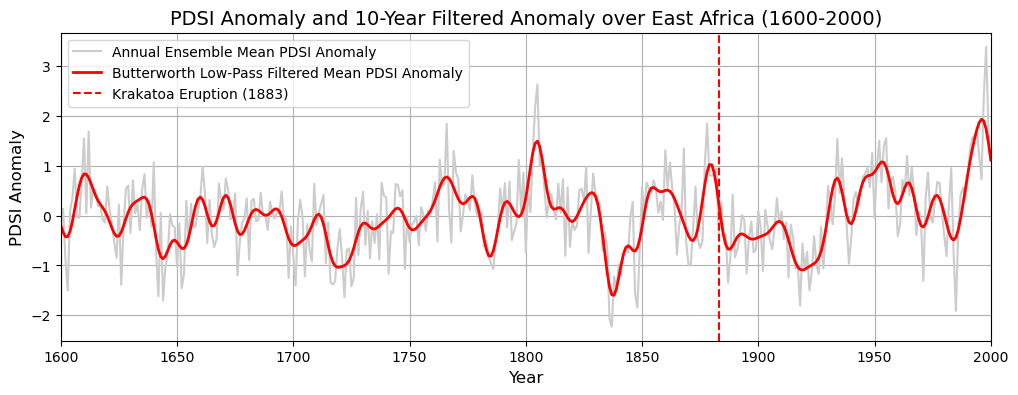

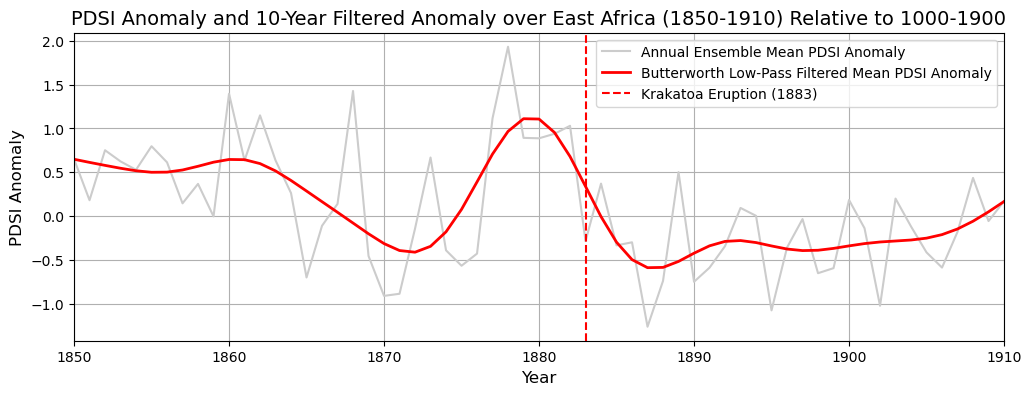

In [140]:
def plot_annual_mean_and_filtered_pdsi(time, annual_mean_pdsi_shifted, filter_output_shifted, title):
    plt.figure(figsize=(12, 4))
    
    #plot the annual mean PDSI in grayscale
    plt.plot(time, annual_mean_pdsi_shifted, color='0.8', linestyle='-', label='Annual Ensemble Mean PDSI Anomaly')
    
    #plot the 10-year filtered PDSI in red
    plt.plot(time, filter_output_shifted, color='red', linestyle='-', linewidth=2, label='Butterworth Low-Pass Filtered Mean PDSI Anomaly')
    
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('PDSI Anomaly', fontsize=12)
    plt.axvline(x=1883, color='red', linestyle='--', label='Krakatoa Eruption (1883)')
    plt.title(title, fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.xlim(time.min(), time.max())
    plt.show()

start_year = 1600
end_year = 2000
lat_slice = slice(-14, 15)
lon_slice = slice(28, 53)

#Need to subset dataset for the spatial slice
east_africa = pdsi_dataset.sel(lat=lat_slice, lon=lon_slice)

#Extract the PDSI variable
pdsi_ens = east_africa['pdsi_ens']

#Weight the PDSI by the cosine of latitude
cos_lat = np.cos(np.deg2rad(east_africa['lat']))
weighted_pdsi_ens = east_africa['pdsi_ens'] * cos_lat

#Ensemble mean, mean over lat and lon, time slice, and take anomaly
annual_mean_pdsi = weighted_pdsi_ens.mean(dim='sub_ens').mean(dim=['lat', 'lon'])
annual_mean_pdsi_1600_2000 = annual_mean_pdsi.sel(time=slice(start_year, end_year))
annual_mean_pdsi_shifted = annual_mean_pdsi_1600_2000 - np.mean(annual_mean_pdsi_1600_2000)

#Apply a Butterworth low-pass filter to smooth the PDSI time series
fs = 1  # One sample per year
fc = 1/10  # Cut-off frequency of the filter (10 years)
w = fc / (fs / 2) # Normalize the frequency
b, a = signal.butter(5, w, 'low')
filter_output_shifted = signal.filtfilt(b, a, annual_mean_pdsi_shifted)

time = annual_mean_pdsi_shifted['time'].values

#Execute the function
plot_annual_mean_and_filtered_pdsi(time, annual_mean_pdsi_shifted, filter_output_shifted, 
                                    'PDSI Anomaly and 10-Year Filtered Anomaly over East Africa (1600-2000)')

start_year = 1850
end_year = 1910

annual_mean_pdsi_1850_1910 = annual_mean_pdsi.sel(time=slice(start_year, end_year))
annual_mean_pdsi_shifted = annual_mean_pdsi_1850_1910 - np.mean(annual_mean_pdsi_1850_1910)

#Calculate the average PDSI for 1000 to 1900
annual_mean_pdsi_1000_1900 = annual_mean_pdsi.sel(time=slice(1000, 1900))
pdsi_anomaly = annual_mean_pdsi_1850_1910 - np.mean(annual_mean_pdsi_1000_1900)

#Butterworth low-pass filter to smooth the PDSI anomaly time series
filter_output_shifted = signal.filtfilt(b, a, pdsi_anomaly)

time = pdsi_anomaly['time'].values

#Function
plot_annual_mean_and_filtered_pdsi(
    time, 
    pdsi_anomaly, 
    filter_output_shifted, 
    'PDSI Anomaly and 10-Year Filtered Anomaly over East Africa (1850-1910) Relative to 1000-1900'
)

Now, let's split the data into periods before and after the eruption and make two histograms. We can use a ks test to determine if the two histograms come from the same parent distribution (eruption didn't change anything) or different distributions (the eruption may have changed something).

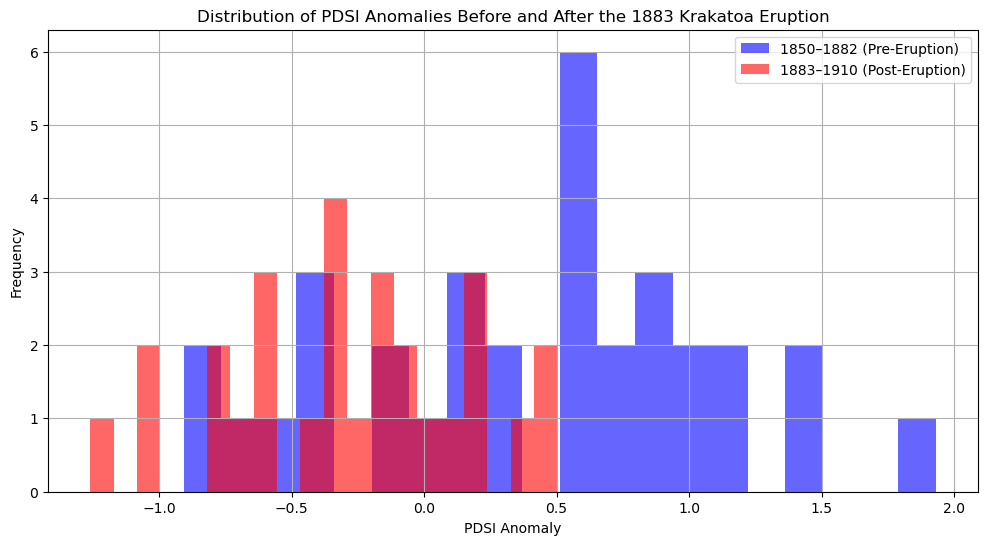

KstestResult(statistic=0.5454545454545454, pvalue=0.00010275285648175009, statistic_location=0.5025099720097502, statistic_sign=-1)


In [136]:
# Split data into pre-eruption and post-eruption periods
pdsi_anomaly_pre = pdsi_anomaly.sel(time=slice(1850, 1882))
pdsi_anomaly_post = pdsi_anomaly.sel(time=slice(1883, 1910))

# Plot histograms
plt.figure(figsize=(12, 6))

# Pre-eruption histogram
plt.hist(pdsi_anomaly_pre, bins=20, alpha=0.6, color='blue', label='1850–1882 (Pre-Eruption)')

# Post-eruption histogram
plt.hist(pdsi_anomaly_post, bins=20, alpha=0.6, color='red', label='1883–1910 (Post-Eruption)')

plt.xlabel('PDSI Anomaly')
plt.ylabel('Frequency')
plt.title('Distribution of PDSI Anomalies Before and After the 1883 Krakatoa Eruption')
plt.legend()
plt.grid(True)
plt.show()

pdsi_anomaly_pre_values = pdsi_anomaly_pre.values
pdsi_anomaly_post_values = pdsi_anomaly_post.values
kstest = scipy.stats.kstest(pdsi_anomaly_pre_values, pdsi_anomaly_post_values)
print(kstest)

The ks test p-value is less than 0.05, so there is 95% confidence that the two samples come from different parent distributions.

Now, it would be excellent if we could create a list of years without volcanism, so that we can pinpoint those years in PHYDA to create 95% confidence bounds for control (non-volcanic) years. I used the eVolv2k dataset, which utilizes sulfate records and ice cores from Greenland and Antarctica to pinpoint volcanic events from 500 BCE to 1900 CE ([Toohey & Sigl](https://doi.org/10.1073/pnas.2019145118)). The dataset is available from the World Data Center for Climate ([WDCC](https://www.wdc-climate.de/ui/)), which requires a membership, so I cannot use pooch to access it. I was approved for a membership and downloaded the NetCDF file and provided it in the GitHub repository.

In [113]:
volcanoes = '../eVolv2k_v3_ds_1.nc'
volcano_data = xr.open_dataset(volcanoes)
print(volcano_data)

<xarray.Dataset>
Dimensions:     (nerup: 256)
Dimensions without coordinates: nerup
Data variables:
    year        (nerup) float64 ...
    yearCE      (nerup) float64 ...
    month       (nerup) float64 ...
    day         (nerup) float64 ...
    lat         (nerup) float64 ...
    vssi        (nerup) float64 ...
    hemi        (nerup) float64 ...
    sigma_vssi  (nerup) float64 ...
Attributes:
    title:      Ice core-inferred volcanic stratospheric sulfur injection (VS...
    history:    Created Thu Jul 11 16:51:32 2019
    reference:  Toohey and Sigl (2017) doi:10.5194/essd-9-809-2017
    comment:    Minor update from v2, includes reassignment of eruption regio...


In [115]:
volcanic_years = volcano_data['yearCE']
volcanic_years.values

array([1890., 1886., 1883., 1875., 1873., 1861., 1856., 1853., 1846.,
       1835., 1831., 1822., 1821., 1815., 1809., 1797., 1796., 1786.,
       1783., 1770., 1766., 1762., 1755., 1739., 1729., 1721., 1720.,
       1707., 1695., 1693., 1673., 1667., 1662., 1654., 1646., 1640.,
       1637., 1621., 1600., 1595., 1590., 1585., 1576., 1567., 1554.,
       1541., 1537., 1528., 1512., 1510., 1505., 1502., 1480., 1478.,
       1477., 1470., 1463., 1458., 1453., 1448., 1441., 1414., 1389.,
       1381., 1378., 1345., 1341., 1336., 1329., 1306., 1286., 1276.,
       1269., 1260., 1257., 1236., 1230., 1222., 1210., 1200., 1191.,
       1182., 1180., 1171., 1137., 1127., 1118., 1115., 1108., 1092.,
       1067., 1064., 1057., 1039., 1028., 1020., 1011., 1003.,  998.,
        990.,  982.,  976.,  970.,  960.,  958.,  953.,  946.,  939.,
        929.,  916.,  908.,  904.,  900.,  880.,  879.,  876.,  869.,
        859.,  853.,  853.,  841.,  835.,  827.,  822.,  819.,  817.,
        800.,  782.,

In [117]:
start_year = 1000
end_year = 1900

#Need to create an array of all years in the range
all_years = np.arange(start_year, end_year + 1)

#Identify non-volcanic years by excluding volcanic years from all years
non_volcanic_years = np.setdiff1d(all_years, volcanic_years)
print(f"Non-volcanic years: {non_volcanic_years}")

Non-volcanic years: [1000 1001 1002 1004 1005 1006 1007 1008 1009 1010 1012 1013 1014 1015
 1016 1017 1018 1019 1021 1022 1023 1024 1025 1026 1027 1029 1030 1031
 1032 1033 1034 1035 1036 1037 1038 1040 1041 1042 1043 1044 1045 1046
 1047 1048 1049 1050 1051 1052 1053 1054 1055 1056 1058 1059 1060 1061
 1062 1063 1065 1066 1068 1069 1070 1071 1072 1073 1074 1075 1076 1077
 1078 1079 1080 1081 1082 1083 1084 1085 1086 1087 1088 1089 1090 1091
 1093 1094 1095 1096 1097 1098 1099 1100 1101 1102 1103 1104 1105 1106
 1107 1109 1110 1111 1112 1113 1114 1116 1117 1119 1120 1121 1122 1123
 1124 1125 1126 1128 1129 1130 1131 1132 1133 1134 1135 1136 1138 1139
 1140 1141 1142 1143 1144 1145 1146 1147 1148 1149 1150 1151 1152 1153
 1154 1155 1156 1157 1158 1159 1160 1161 1162 1163 1164 1165 1166 1167
 1168 1169 1170 1172 1173 1174 1175 1176 1177 1178 1179 1181 1183 1184
 1185 1186 1187 1188 1189 1190 1192 1193 1194 1195 1196 1197 1198 1199
 1201 1202 1203 1204 1205 1206 1207 1208 1209 1211 1212 1

Now we can use the PDSI anomaly from our non-volcanic years to create 95% confidence levels for the time period we were working with before.

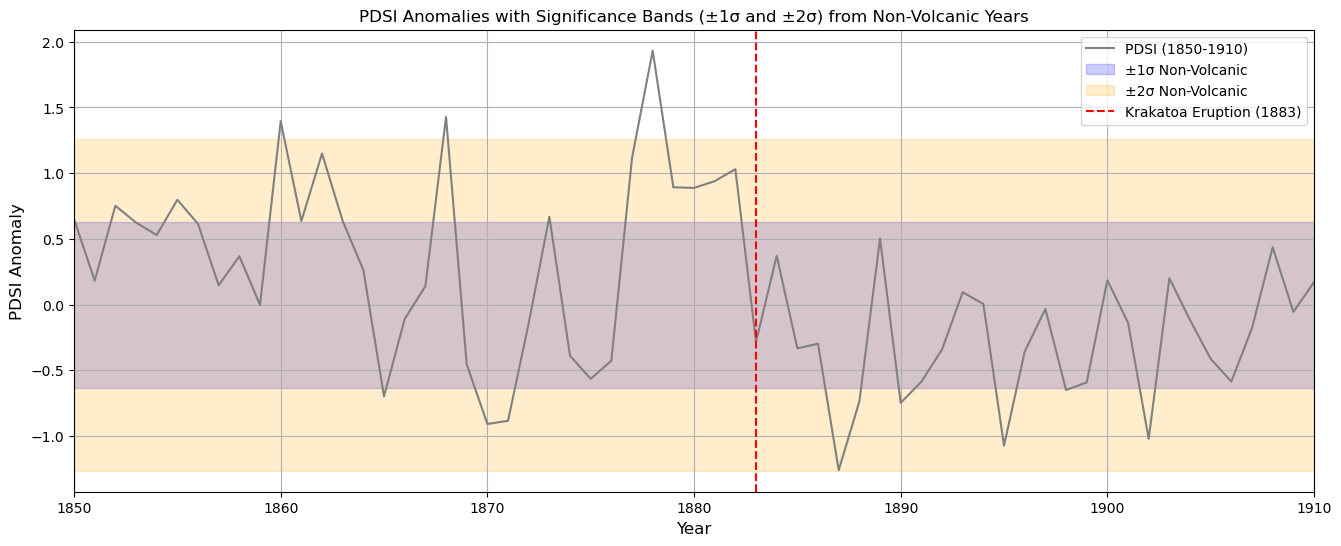

In [138]:
#Extract PDSI data for non-volcanic years
pdsi_non_volcanic = annual_mean_pdsi.sel(time=non_volcanic_years)
pdsi_detrended = pdsi_non_volcanic - pdsi_non_volcanic.mean()

#Calculate the significance bands (mean ± 1 and 2 standard deviations)
mean_non_volcanic = pdsi_detrended.mean()
std_non_volcanic = pdsi_detrended.std()
upper_band_1sigma = mean_non_volcanic + std_non_volcanic
lower_band_1sigma = mean_non_volcanic - std_non_volcanic
upper_band_2sigma = mean_non_volcanic + 2 * std_non_volcanic
lower_band_2sigma = mean_non_volcanic - 2 * std_non_volcanic

# Plot the timeseries with significance bands
plt.figure(figsize=(16, 6))
plt.plot(time, pdsi_anomaly, color='0.5', linestyle='-', label='PDSI (1850-1910)')
plt.fill_between(time, upper_band_1sigma, lower_band_1sigma, color='blue', alpha=0.2, label='±1σ Non-Volcanic')
plt.fill_between(time, upper_band_2sigma, lower_band_2sigma, color='orange', alpha=0.2, label='±2σ Non-Volcanic')
plt.axvline(x=1883, color='red', linestyle='--', label='Krakatoa Eruption (1883)')
plt.xlabel('Year', fontsize=12)
plt.ylabel('PDSI Anomaly', fontsize=12)
plt.title('PDSI Anomalies with Significance Bands (±1σ and ±2σ) from Non-Volcanic Years')
plt.legend(loc = 'upper right')
plt.xlim(time.min(), time.max())
plt.grid(True)
plt.show()

There is no PDSI anomaly perturbation over East Africa occuring after the Krakatoa eruption at 95% confidence.

Now, let's see if we can learn anything by applying the same analysis to temperature.

# Temperature Data Analysis (PHYDA)

In [27]:
# Disable SSL warnings
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
url_temp = "https://clifford.ldeo.columbia.edu/nsteiger/recon_output/phyda_ens/phyda_ens_tas_AprMar_r.1-2000_d.21-Nov-2018.nc"

# Custom downloader to disable SSL verification
downloader = pooch.HTTPDownloader(progressbar=True, verify=False)

try:
    dataset_file_temp = pooch.retrieve(
        url=url_temp,
        known_hash=None,
        downloader=downloader,
    )

    # Load the dataset using xarray
    tas_dataset = xr.open_dataset(dataset_file_temp)
    print(tas_dataset)

except Exception as e:
    print(f"Error retrieving or processing the file: {e}")

<xarray.Dataset>
Dimensions:  (lat: 96, lon: 144, time: 2000, sub_ens: 100)
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) float64 1.0 2.0 3.0 4.0 ... 1.998e+03 1.999e+03 2e+03
Dimensions without coordinates: sub_ens
Data variables:
    tas_ens  (sub_ens, time, lat, lon) float64 ...
Attributes:
    author:    Nathan Steiger, LDEO Columbia University, Nov 2018
    NCO:       "4.6.2"
    citation:  http://doi.org/10.1038/sdata.2018.86


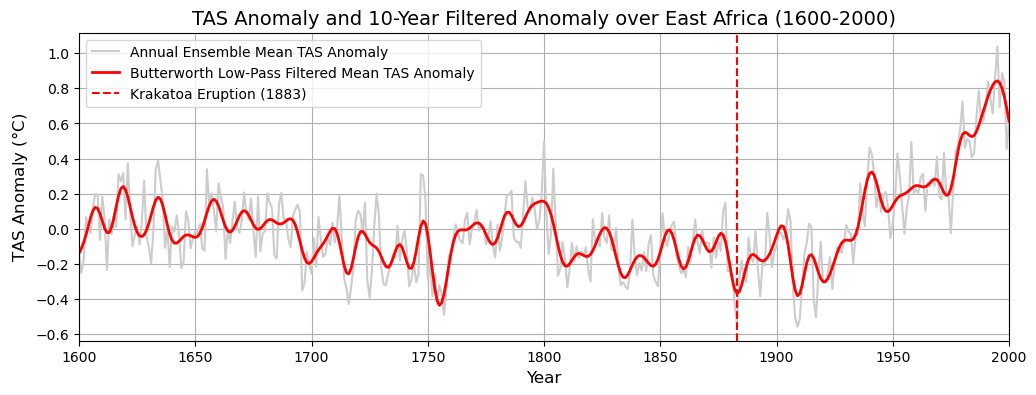

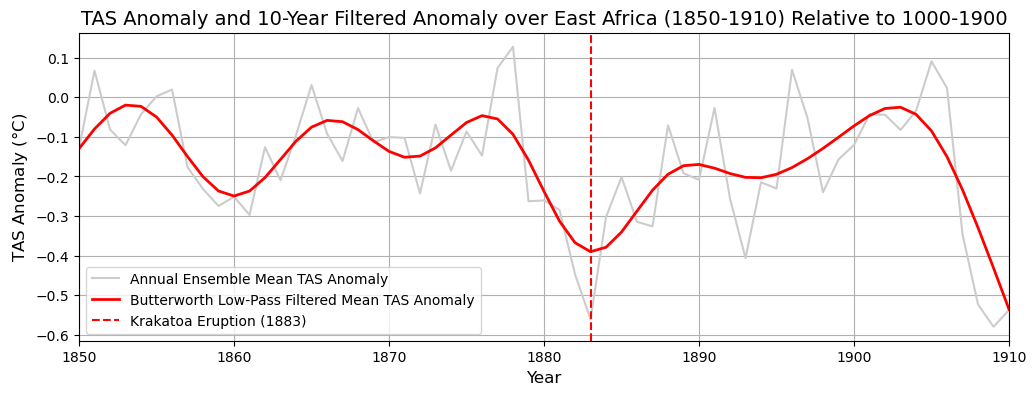

In [150]:
def plot_annual_mean_and_filtered_tas(time, annual_mean_tas_shifted, filter_output_shifted, title):
    plt.figure(figsize=(12, 4))
    
    #plot the annual mean tas in grayscale
    plt.plot(time, annual_mean_tas_shifted, color='0.8', linestyle='-', label='Annual Ensemble Mean TAS Anomaly')
    
    #plot the 10-year filtered tas in red
    plt.plot(time, filter_output_shifted, color='red', linestyle='-', linewidth=2, label='Butterworth Low-Pass Filtered Mean TAS Anomaly')
    
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('TAS Anomaly ($\degree$C)', fontsize=12)
    plt.axvline(x=1883, color='red', linestyle='--', label='Krakatoa Eruption (1883)')
    plt.title(title, fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.xlim(time.min(), time.max())
    plt.show()

start_year = 1600
end_year = 2000
lat_slice = slice(-14, 15)
lon_slice = slice(28, 53)

#Need to subset dataset for the spatial slice
east_africa = tas_dataset.sel(lat=lat_slice, lon=lon_slice)

#Extract the tas variable
tas_ens = east_africa['tas_ens']

#Weight the tas by the cosine of latitude
cos_lat = np.cos(np.deg2rad(east_africa['lat']))
weighted_tas_ens = east_africa['tas_ens'] * cos_lat

#Ensemble mean, mean over lat and lon, time slice, and take anomaly
annual_mean_tas = weighted_tas_ens.mean(dim='sub_ens').mean(dim=['lat', 'lon'])
annual_mean_tas_1600_2000 = annual_mean_tas.sel(time=slice(start_year, end_year))
annual_mean_tas_shifted = annual_mean_tas_1600_2000 - np.mean(annual_mean_tas_1600_2000)

#Apply a Butterworth low-pass filter to smooth the tas time series
fs = 1  # One sample per year
fc = 1/10  # Cut-off frequency of the filter (10 years)
w = fc / (fs / 2) # Normalize the frequency
b, a = signal.butter(5, w, 'low')
filter_output_shifted = signal.filtfilt(b, a, annual_mean_tas_shifted)

time = annual_mean_tas_shifted['time'].values

#Execute the function
plot_annual_mean_and_filtered_tas(time, annual_mean_tas_shifted, filter_output_shifted, 
                                    'TAS Anomaly and 10-Year Filtered Anomaly over East Africa (1600-2000)')
start_year = 1850
end_year = 1910

annual_mean_tas_1850_1910 = annual_mean_tas.sel(time=slice(start_year, end_year))
annual_mean_tas_shifted = annual_mean_tas_1850_1910 - np.mean(annual_mean_tas_1850_1910)

#Calculate the average tas for 1000 to 1900
annual_mean_tas_1000_1900 = annual_mean_tas.sel(time=slice(1000, 1900))
tas_anomaly = annual_mean_tas_1850_1910 - np.mean(annual_mean_tas_1000_1900)

#Butterworth low-pass filter to smooth the tas anomaly time series
filter_output_shifted = signal.filtfilt(b, a, tas_anomaly)

time = tas_anomaly['time'].values

#Function
plot_annual_mean_and_filtered_tas(
    time, 
    tas_anomaly, 
    filter_output_shifted, 
    'TAS Anomaly and 10-Year Filtered Anomaly over East Africa (1850-1910) Relative to 1000-1900'
)

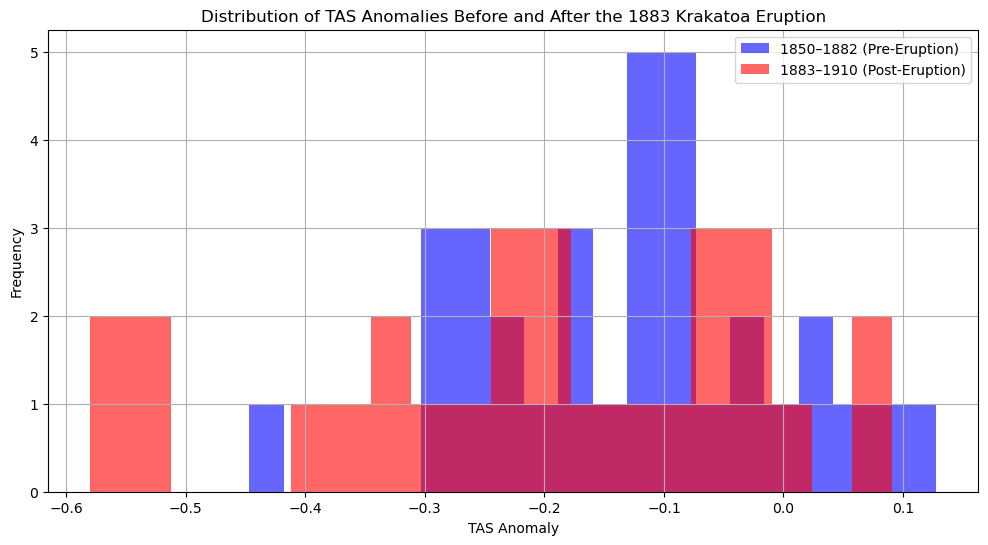

KstestResult(statistic=0.2911255411255411, pvalue=0.1189398159171334, statistic_location=-0.3028928970179763, statistic_sign=-1)


In [124]:
# Split data into pre-eruption and post-eruption periods
tas_anomaly_pre = tas_anomaly.sel(time=slice(1850, 1882))
tas_anomaly_post = tas_anomaly.sel(time=slice(1883, 1910))

# Plot histograms
plt.figure(figsize=(12, 6))

# Pre-eruption histogram
plt.hist(tas_anomaly_pre, bins=20, alpha=0.6, color='blue', label='1850–1882 (Pre-Eruption)')

# Post-eruption histogram
plt.hist(tas_anomaly_post, bins=20, alpha=0.6, color='red', label='1883–1910 (Post-Eruption)')

plt.xlabel('TAS Anomaly')
plt.ylabel('Frequency')
plt.title('Distribution of TAS Anomalies Before and After the 1883 Krakatoa Eruption')
plt.legend()
plt.grid(True)
plt.show()

tas_anomaly_pre_values = tas_anomaly_pre.values
tas_anomaly_post_values = tas_anomaly_post.values
kstest = scipy.stats.kstest(tas_anomaly_pre_values, tas_anomaly_post_values)
print(kstest)

For the temperature data, the p-value is greater than 0.05, so the parent distributions of the histograms before and after the eruption cannot be distinguished at 95% confidence.

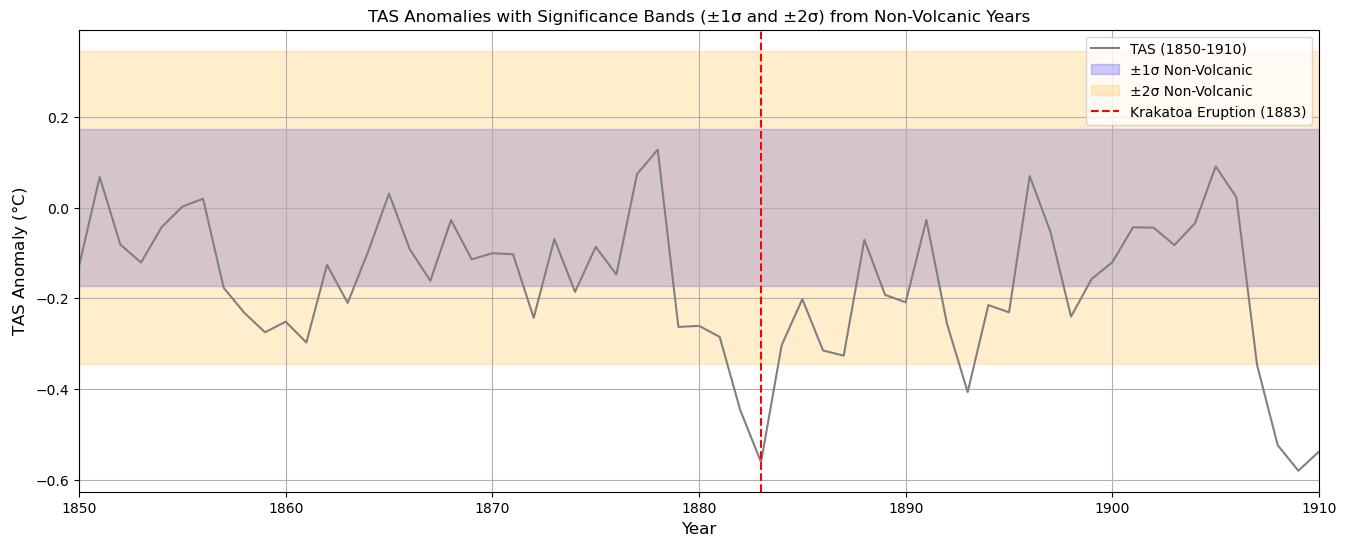

In [152]:
#Extract tas data for non-volcanic years
tas_non_volcanic = annual_mean_tas.sel(time=non_volcanic_years)
tas_detrended = tas_non_volcanic - tas_non_volcanic.mean()

#Calculate the significance bands (mean ± 1 and 2 standard deviations)
mean_non_volcanic = tas_detrended.mean()
std_non_volcanic = tas_detrended.std()
upper_band_1sigma = mean_non_volcanic + std_non_volcanic
lower_band_1sigma = mean_non_volcanic - std_non_volcanic
upper_band_2sigma = mean_non_volcanic + 2 * std_non_volcanic
lower_band_2sigma = mean_non_volcanic - 2 * std_non_volcanic

# Plot the timeseries with significance bands
plt.figure(figsize=(16, 6))
plt.plot(time, tas_anomaly, color='0.5', linestyle='-', label='TAS (1850-1910)')
plt.fill_between(time, upper_band_1sigma, lower_band_1sigma, color='blue', alpha=0.2, label='±1σ Non-Volcanic')
plt.fill_between(time, upper_band_2sigma, lower_band_2sigma, color='orange', alpha=0.2, label='±2σ Non-Volcanic')
plt.axvline(x=1883, color='red', linestyle='--', label='Krakatoa Eruption (1883)')
plt.xlabel('Year', fontsize=12)
plt.ylabel('TAS Anomaly ($\degree$C)', fontsize=12)
plt.title('TAS Anomalies with Significance Bands (±1σ and ±2σ) from Non-Volcanic Years')
plt.legend(loc = 'upper right')
plt.grid(True)
plt.xlim(time.min(), time.max())
plt.show()

Unlike the PDSI data, the temperature data does have a statistically significant perturbation in the eruption year. This is expected, since the volcanic eruption would emit sulfur dioxide, which can react in the atmosphere and reflect incoming shortwave radiation.

Now, let's investigate CMIP6 to see if soil moisture data from another model ensemble agrees with the PDSI data from PHYDA.

# Soil Moisture Data Analysis (CMIP6)

In [39]:
col = google_cmip_col()
cat = col.search(
    variable_id='mrso', # mass of water in soil integrated over all layers
    experiment_id='historical',
    grid_label='gn',
   # member_id='10',
)
cat

,unique
activity_id,1
institution_id,20
source_id,33
experiment_id,1
member_id,136
table_id,2
variable_id,1
grid_label,1
zstore,347
dcpp_init_year,0


In [41]:
df = cat.df  # Get the full catalog as a Pandas DataFrame
ensemble_counts = df.groupby('source_id')['member_id'].nunique()
models_with_15_plus = ensemble_counts[ensemble_counts >= 15].index.tolist()
print(models_with_15_plus)

['ACCESS-ESM1-5', 'CanESM5', 'GISS-E2-1-G', 'GISS-E2-1-H', 'MIROC6', 'UKESM1-0-LL']


For this analysis, I will be using the CMIP variable mrso, which is the mass of water in soil integrated over all layers of depth.

In [44]:
cat_filtered = col.search(
    variable_id='mrso',
    experiment_id='historical',
    grid_label='gn',
    source_id=models_with_15_plus,
)

In [46]:
# read all datasets into a dictionary but apply the xmip preprocessing before
ddict = cat_filtered.to_dataset_dict(
    preprocess=combined_preprocessing,
    xarray_open_kwargs={'use_cftime':True}, # decode time units to the Climate and Forecasting (CF) netCDF conventions
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


I want to find the model with the most ensemble members, since an increased number of members will increase the degrees of freedom of my analysis.

In [48]:
ensemble_sizes = {}

#loop through each ensemble in the dictionary
for ensemble_name, ensemble_data in ddict.items():
    #Count the number of members
    num_members = len(ensemble_data['member_id'])
    ensemble_sizes[ensemble_name] = num_members

#find the ensemble with the most members
max_ensemble = max(ensemble_sizes, key=ensemble_sizes.get)
max_members = ensemble_sizes[max_ensemble]

print(f"The ensemble with the most members is: {max_ensemble} with {max_members} members.")

The ensemble with the most members is: CMIP.MIROC.MIROC6.historical.Lmon.gn with 50 members.


In [50]:
ds1 = ddict['CMIP.MIROC.MIROC6.historical.Lmon.gn']
ds1

<xarray.Dataset>
Dimensions:         (member_id: 50, dcpp_init_year: 1, time: 1980, y: 128,
                     x: 256, bnds: 2, vertex: 4)
Coordinates:
  * y               (y) float64 -88.93 -87.54 -86.14 ... 86.14 87.54 88.93
  * x               (x) float64 0.0 1.406 2.812 4.219 ... 355.8 357.2 358.6
  * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    lat_bounds      (y, bnds, x) float64 dask.array<chunksize=(128, 2, 256), meta=np.ndarray>
    lon_bounds      (x, bnds, y) float64 dask.array<chunksize=(256, 2, 128), meta=np.ndarray>
    time_bounds     (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
    lon             (x, y) float64 360.0 360.0 360.0 360.0 ... 358.6 358.6 358.6
    lat             (x, y) float64 -88.93 -87.54 -86.14 ... 86.14 87.54 88.93
    lon_verticies   (vertex, x, y) float64 dask.array<chunksize=(1, 256, 128), meta=np.ndarray>
    lat_verticies   (vertex, x, y) float64 dask.array<chunksize=(1, 256, 128), meta=np.ndarray>
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' ... 'r9i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
Dimensions without coordinates: bnds, vertex
Data variables:
    mrso            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 128, 256), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    experiment:                       all-forcing simulation of the recent past
    experiment_id:                    historical
    ...                               ...
    intake_esm_attrs:experiment_id:   historical
    intake_esm_attrs:table_id:        Lmon
    intake_esm_attrs:variable_id:     mrso
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.MIROC.MIROC6.historical.Lmon.gn

Unlike the PHYDA, this data has monthly temporal resolution, so I need to be sure to address that, as well as the Proleptic Gregorian datetime format.

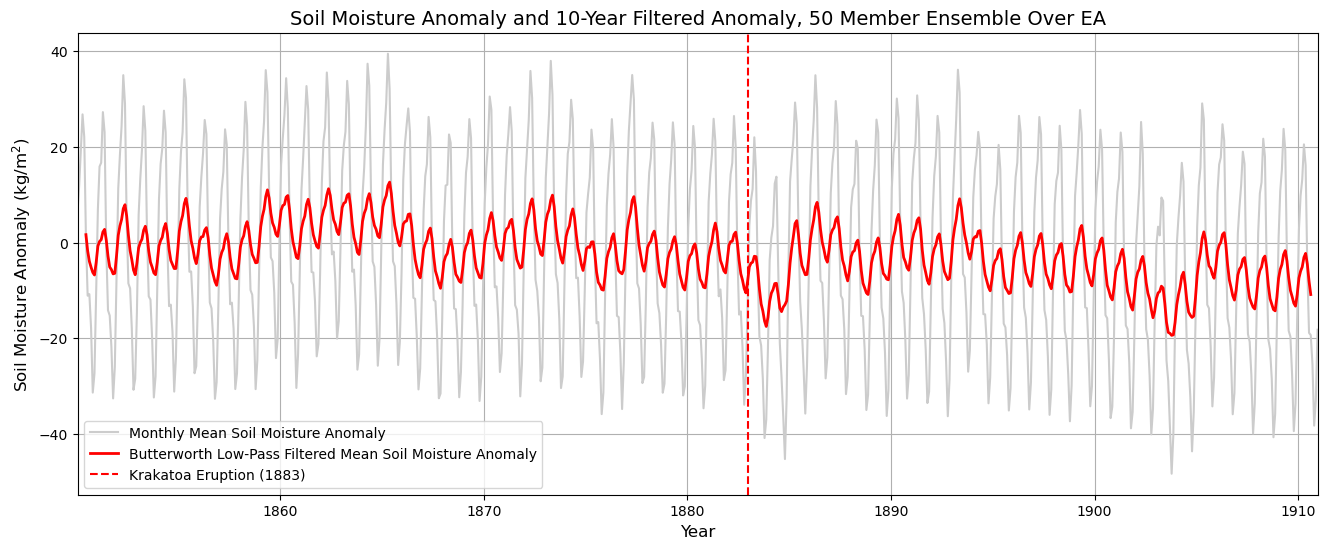

In [154]:
def plot_monthly_mean_and_filtered_soil_moisture(time, soil_moisture_anomaly, filtered_output, title):
    plt.figure(figsize=(16, 6))
    
    #monthly mean soil moisture anomalies in grayscale
    plt.plot(time, soil_moisture_anomaly, color='0.8', linestyle='-', label='Monthly Mean Soil Moisture Anomaly')
    
    #10-year filtered soil moisture anomalies in red
    plt.plot(time, filtered_output, color='red', linestyle='-', linewidth=2, label='Butterworth Low-Pass Filtered Mean Soil Moisture Anomaly')
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Soil Moisture Anomaly (kg/m$^{2}$)', fontsize=12)
    plt.axvline(x=np.datetime64('1883-01-01'), color='red', linestyle='--', label='Krakatoa Eruption (1883)')
    plt.title(title, fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.xlim(time.min(), time.max())
    plt.show()
    
#Extract soil moisture
soil_moisture = ds1['mrso']

#Average over ensemble members
avg_soil_moisture = soil_moisture.mean(dim='member_id')  #Shape: (dcpp_init_year, time, y, x)

#Subset data for East Africa
start_year = cftime.DatetimeProlepticGregorian(1850, 1, 1)
end_year = cftime.DatetimeProlepticGregorian(1910, 12, 31)
y_slice = slice(-14, 15)  # Latitude-like range in 'y'
x_slice = slice(28, 53)   # Longitude-like range in 'x'
east_africa = avg_soil_moisture.sel(time=slice(start_year, end_year), y=y_slice, x=x_slice)

#Apply cosine weighting
cos_y = np.cos(np.deg2rad(east_africa['y']))
weighted_soil_moisture = east_africa * cos_y

#Compute mean over y, x
monthly_mean_soil_moisture = weighted_soil_moisture.mean(dim=['y', 'x'])

#Calculate pre-eruption mean
pre_eruption = monthly_mean_soil_moisture.sel(
    time=slice(start_year, cftime.DatetimeProlepticGregorian(1882, 12, 31))
).mean()

#Compute anomaly
soil_moisture_anomaly = monthly_mean_soil_moisture - pre_eruption

#Convert CFTime to numpy datetime for plotting
time = np.array([np.datetime64(t.isoformat()) for t in soil_moisture_anomaly['time'].values])

#Apply moving average using pandas (rolling window)
anomaly_series = pd.Series(soil_moisture_anomaly.values.squeeze())
filtered_output = anomaly_series.rolling(window=10, center=True).mean().values

#Plot function
plot_monthly_mean_and_filtered_soil_moisture(
    time,
    soil_moisture_anomaly.values.squeeze(),  # 1D array
    filtered_output,  # 1D array
    "Soil Moisture Anomaly and 10-Year Filtered Anomaly, 50 Member Ensemble Over EA"
)


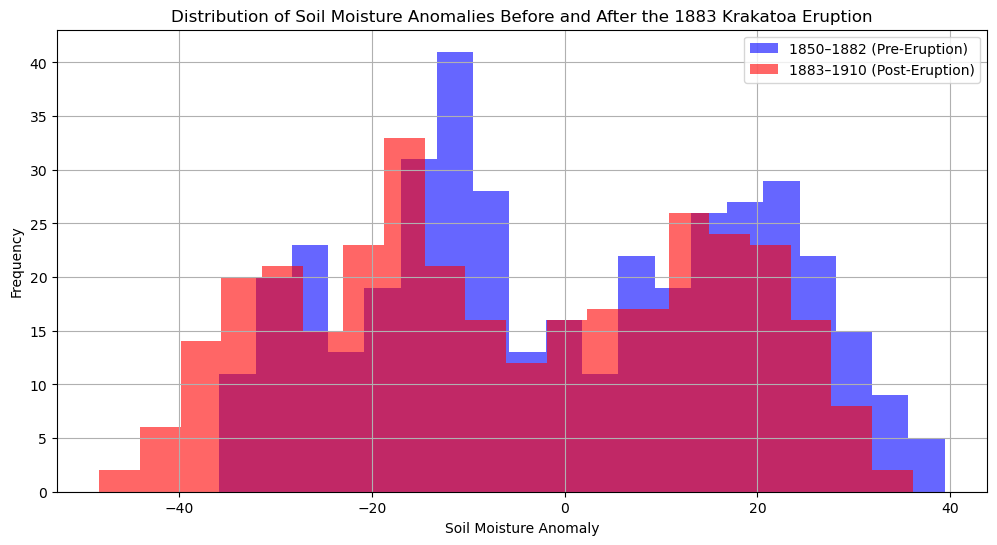

KstestResult(statistic=0.14521084337349396, pvalue=0.0008242237067894109, statistic_location=-13.544977181016293, statistic_sign=-1)


In [59]:

start_year_pre = cftime.DatetimeProlepticGregorian(1850, 1, 1)
end_year_pre = cftime.DatetimeProlepticGregorian(1883, 4, 30)
start_year_post = cftime.DatetimeProlepticGregorian(1883, 5, 1)
end_year_post = cftime.DatetimeProlepticGregorian(1910, 12, 31)
# Split data into pre-eruption and post-eruption periods
soil_moisture_anomaly_pre = soil_moisture_anomaly.sel(time=slice(start_year_pre, end_year_pre))
soil_moisture_anomaly_post = soil_moisture_anomaly.sel(time=slice(start_year_post, end_year_post))

soil_moisture_anomaly_pre_values = soil_moisture_anomaly_pre.values.flatten()
soil_moisture_anomaly_post_values = soil_moisture_anomaly_post.values.flatten()

# Plot histograms
plt.figure(figsize=(12, 6))

# Pre-eruption histogram
plt.hist(soil_moisture_anomaly_pre_values, bins=20, alpha=0.6, color='blue', label='1850–1882 (Pre-Eruption)')

# Post-eruption histogram
plt.hist(soil_moisture_anomaly_post_values, bins=20, alpha=0.6, color='red', label='1883–1910 (Post-Eruption)')

plt.xlabel('Soil Moisture Anomaly')
plt.ylabel('Frequency')
plt.title('Distribution of Soil Moisture Anomalies Before and After the 1883 Krakatoa Eruption')
plt.legend()
plt.grid(True)
plt.show()

kstest = scipy.stats.kstest(soil_moisture_anomaly_pre_values, soil_moisture_anomaly_post_values)
print(kstest)

This analysis has a p-value less than 0.05, so we are 95% confident that the curves before and after the eruption represent different parent distributions.

# Conclusion

The takeaways of this analysis are as follows:

1. PDSI and soil moisture anomaly distributions over East Africa were statistically significantly different over East Africa before and after the eruption. PDSI did not exhibit a statistically significant perturbation immediately after the eruption.
2. Temperature anomaly distributions over East Africa were not statistically significantly different over East Africa before and after the eruption. However, temperature did exhibit a statistically significant perturbation immediately after the eruption.

This could suggest that the effects of the Krakatoa eruption on East African temperature exhibited a high magnitude on a short timescale, but did not shift the distribution over the following decades. Conversely, the eruption's effects on East African PDSI were not immediately significant, but the eruption significantly shifted the distribution of PDSI and soil moisture over the following decades.

My next steps for this project involve the Indian Ocean Dipole (IOD) and the El Niño-Southern Oscillation (ENSO). There is evidence that on multidecadal timescales, the hydroclimate of East Africa is driven by the IOD's influence on the local Walker Circulation ([Tierney et al.](https://www.nature.com/articles/nature11785)). My work for my QMDA final project involved investigating the wavelet coherence of the IOD, ENSO, and East African PDSI. I can combine that project and this one to investigate SSTs after the Krakatoa eruption and how they relate to hydroclimate. Additionally, East Africa has a bimodal precipitation cycle, with "long" rains in March-May, and "short" rains in October-December ([Palmer et al.](https://www.nature.com/articles/s43017-023-00397-x)). I intend to investigate the eruption's effect on these seasonal hydroclimatic cycles.